# Computation of the lead-field matrix

The lead-field matrix is a mathematical representation that describes the relationship between the electrical activity generated by neural sources in the brain and the resulting electrical measurements observed on the scalp's surface during EEG recordings.

The focus in this Notebook is on constructing a lead-field matrix that corresponds to the Automated Anatomical Labeling 2 (AAL2) atlas, a widely used brain parcellation scheme that divides the brain into regions based on anatomical landmarks. This atlas provides a comprehensive map of brain regions, allowing to associate EEG measurements with specific anatomical structures.

We utilized the standard 1020 EEG electrode configuration, which is a well-established system for scalp EEG recordings, involves employing a specific arrangement of electrode placement points on the scalp. By aligning the Automated Anatomical Labeling 2 (AAL2) atlas with the 1020 EEG electrode configuration, the primary aim of this Notebook is to establish a direct link between distinct brain regions defined by the AAL2 atlas and the specific EEG recording channels.

In [1]:
# Authors: 
#          Zixuan liu <zixuan.liu@campus.tu-berlin.de> 
#          Mohammad Orabe <orabe.mhd@gmail.com>

# change to the root directory of the project
import os

if os.getcwd().split("/")[-1] == "examples":
    os.chdir("..")

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import annotations
from importlib import import_module
import subprocess
import sys


named_libs = [
    ("matplotlib.pyplot", "plt"),
    ("nibabel", "nib"),
    ("mne", "mne"),
    ("neurolib", "neurolib"),
    ("pandas", "pd"),
    ("numpy","np")
]

for name, short in named_libs:
    try:
        globals()[short] = import_module(name)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", name])
        globals()[short] = import_module(name)

In [3]:
from neurolib.utils.leadfield import LeadfieldGenerator


In [4]:
subject = "fsaverage"

atlas_xml_path = os.path.join(
    "examples", "data", "AAL2_atlas_data", "AAL2.xml"
)  # Load the NIfTI file of the AAL2 atlas

atlas_nii_path = os.path.join(
    "examples", "data", "AAL2_atlas_data", "AAL2.nii"
)  # Load the XML file of the AAL2 atlas.


### Download and load the data
Download the template MRI "fsaverage", user-specific data can replace the dataset.

In [5]:
object = LeadfieldGenerator(subject)
object.load_data(subjects_dir=None, subject=subject)
object.load_transformation_file(trans_path=None, subject=subject)


0 files missing from root.txt in /home/ben/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /home/ben/mne_data/MNE-fsaverage-data/fsaverage
Load template data 'fsaverage'
Load default transformation file of 'fsaverage'


### Set conductivity of tissues and compute BEM
Setting conductivity based on the type of the tissues, calculate the BEM of the data, further visualize BEM surfaces.

Creating the BEM geometry...
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
Nearest-neighbor searches will be significantly faster if scikit-learn is installed.
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
Nearest-neighbor searches will be significantly faster if scikit-learn is installed.
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
Nearest-neighbor searches will be significantly faster if scikit-learn is installed.
outer skin  CM is  -0.21 -19.38  -0.23 mm
outer skull CM is  -0.19 -19.34  -0.49 mm
inner skull CM is  -0.53 -21.10   6.21 mm
Checking that surface outer skull is inside surface outer skin  ...
Checking that surface inner skull is inside surface outer skull ...
Nearest-neighbor searches will be significantly faster if scikit-learn is installed.
Checking distance between outer skin  and outer skull surfaces...
Minimum distance between the outer skin  and outer skull surfaces is approxima

/home/ben/anaconda3/envs/NP_py37/lib/python3.7/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


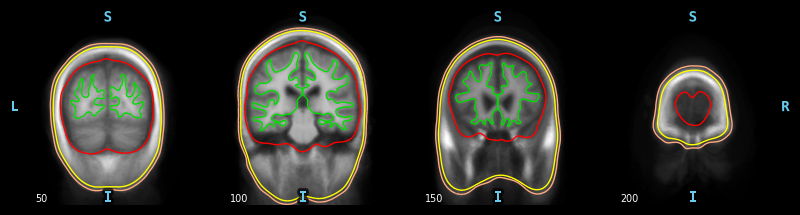

In [6]:
bem, plot_bem_kwargs_default = object.build_BEM(
    conductivity=(0.3, 0.006, 0.3),
    visualization=True,
    brain_surfaces="white",
    orientation="coronal",
    slices=[50, 100, 150, 200],
)


### Generate surface source space
The method to achieve AAL atlas source space is to calculate the average dipole value of all dipoles in each annotation of the atlas, so at first place, the surface source space needed to be generated. The data "fsaverage" has a pre build-up surface source space, nevertheless, the source space can also be calculated.

In [7]:
src = object.generate_surface_source_space(
    plot_bem_kwargs_default, spacing="ico4", add_dist="patch", visualization=True
)


Using surface: /home/ben/mne_data/MNE-fsaverage-data/fsaverage/bem/inner_skull.surf
Using surface: /home/ben/mne_data/MNE-fsaverage-data/fsaverage/bem/outer_skull.surf
Using surface: /home/ben/mne_data/MNE-fsaverage-data/fsaverage/bem/outer_skin.surf
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read


/home/ben/anaconda3/envs/NP_py37/lib/python3.7/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


### Load and coregistrate standard EEG configuration
The standard 1020 EEG electrode locations are already calculated in fsaverage's space (MNI space)

In [8]:
raw = object.EEG_coregistration(src, configuration="standard_1020", visualization=False)


Extracting EDF parameters from /home/ben/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


### Calculate the general forward solution
The overall forward solution between surface source model and standard EEG montage is computed

In [9]:
fwd = object.calculate_general_forward_solution(raw, src, bem, eeg=True, mindist=5.0)


Source space          : /home/ben/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif
MRI -> head transform : /home/ben/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /home/ben/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  64 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

### Downsample the forward solution to achieve lead-field matrix
With the forward solution that being calculated above, compute the average dipole value of the dipoles in each AAL2 atlas to acquire the lead-field matrix.

 This part is majorly the contribution from Dr Nikola Jajcay and Martin Krück

In [10]:
leadfield_downsampled, unique_labels = object.compute_downsampled_leadfield(
    fwd,
    atlas_nii_path=atlas_nii_path,
    atlas_xml_path=atlas_xml_path,
    atlas="aal2_cortical",
    cortex_parts="only_cortical_parts",
    path_to_save=None,
)


    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Changing to fixed-orientation forward solution with surface-based source orientations...
    [done]


Lead-field matrix's size : 64 sensors x 80 dipoles
Downsampled lead-field matrix: [[ 46.04994965  -8.10410786  51.77441025 ...  -2.94834971 -23.09642601
  -19.40756226]
 [ 63.07709122  -3.93809891  81.55700684 ...  -4.37600708 -29.43244171
  -22.51299858]
 [ 45.61449051   4.5890007   83.16113281 ...  -5.45585632 -29.02486992
  -24.48497391]
 ...
 [-17.10591125 -12.98497009 -18.8378315  ... -17.25889778   6.94999075
    5.47342777]
 [-17.8266964  -12.14259911 -22.44947052 ... -18.51710701   3.97949266
   17.09414291]
 [-18.07567787 -14.23812962 -20.28104019 ... -16.23433876  19.68776131
   16.43202209]]


### Investigation of the missing regions of AAL2 atlas
The size of downsampled lead-field matrix depends on some setting of the parameters, for example "cortex_parts". The omitted regions can also be reviewed.

In [11]:
object.check_atlas_missing_regions(
    atlas_xml_path=atlas_xml_path, 
    unique_labels=unique_labels
)

total region quantity: 120
missed region quantity:  40
missed region labels: [4101 4102 4111 4112 4201 4202 7001 7002 7011 7012 7021 7022 7101 7102
 9001 9002 9011 9012 9021 9022 9031 9032 9041 9042 9051 9052 9061 9062
 9071 9072 9081 9082 9100 9110 9120 9130 9140 9150 9160 9170]
missed region names: ['Hippocampus_L', 'Hippocampus_R', 'ParaHippocampal_L', 'ParaHippocampal_R', 'Amygdala_L', 'Amygdala_R', 'Caudate_L', 'Caudate_R', 'Putamen_L', 'Putamen_R', 'Pallidum_L', 'Pallidum_R', 'Thalamus_L', 'Thalamus_R', 'Cerebelum_Crus1_L', 'Cerebelum_Crus1_R', 'Cerebelum_Crus2_L', 'Cerebelum_Crus2_R', 'Cerebelum_3_L', 'Cerebelum_3_R', 'Cerebelum_4_5_L', 'Cerebelum_4_5_R', 'Cerebelum_6_L', 'Cerebelum_6_R', 'Cerebelum_7b_L', 'Cerebelum_7b_R', 'Cerebelum_8_L', 'Cerebelum_8_R', 'Cerebelum_9_L', 'Cerebelum_9_R', 'Cerebelum_10_L', 'Cerebelum_10_R', 'Vermis_1_2', 'Vermis_3', 'Vermis_4_5', 'Vermis_6', 'Vermis_7', 'Vermis_8', 'Vermis_9', 'Vermis_10']
missed region indices: [ 41  42  43  44  45  46  75  7

### Calculating simulated EEG data based on simulated source signals and the lead-field matrix
A randomly simulated brain activity was generated, through the multiplication of the lead-field matrix the simulated EEG signals are obtained. The generated EEG data can be ploted, also can be stored as CSV files for further statistical and medical analysis.

The simulated data can be manually generated.

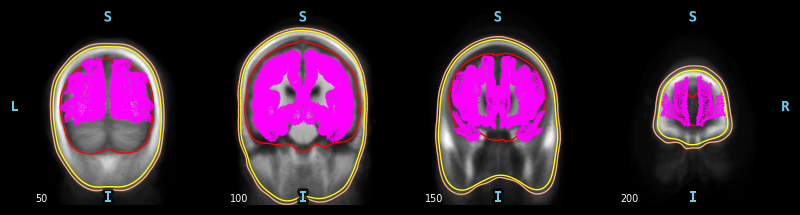

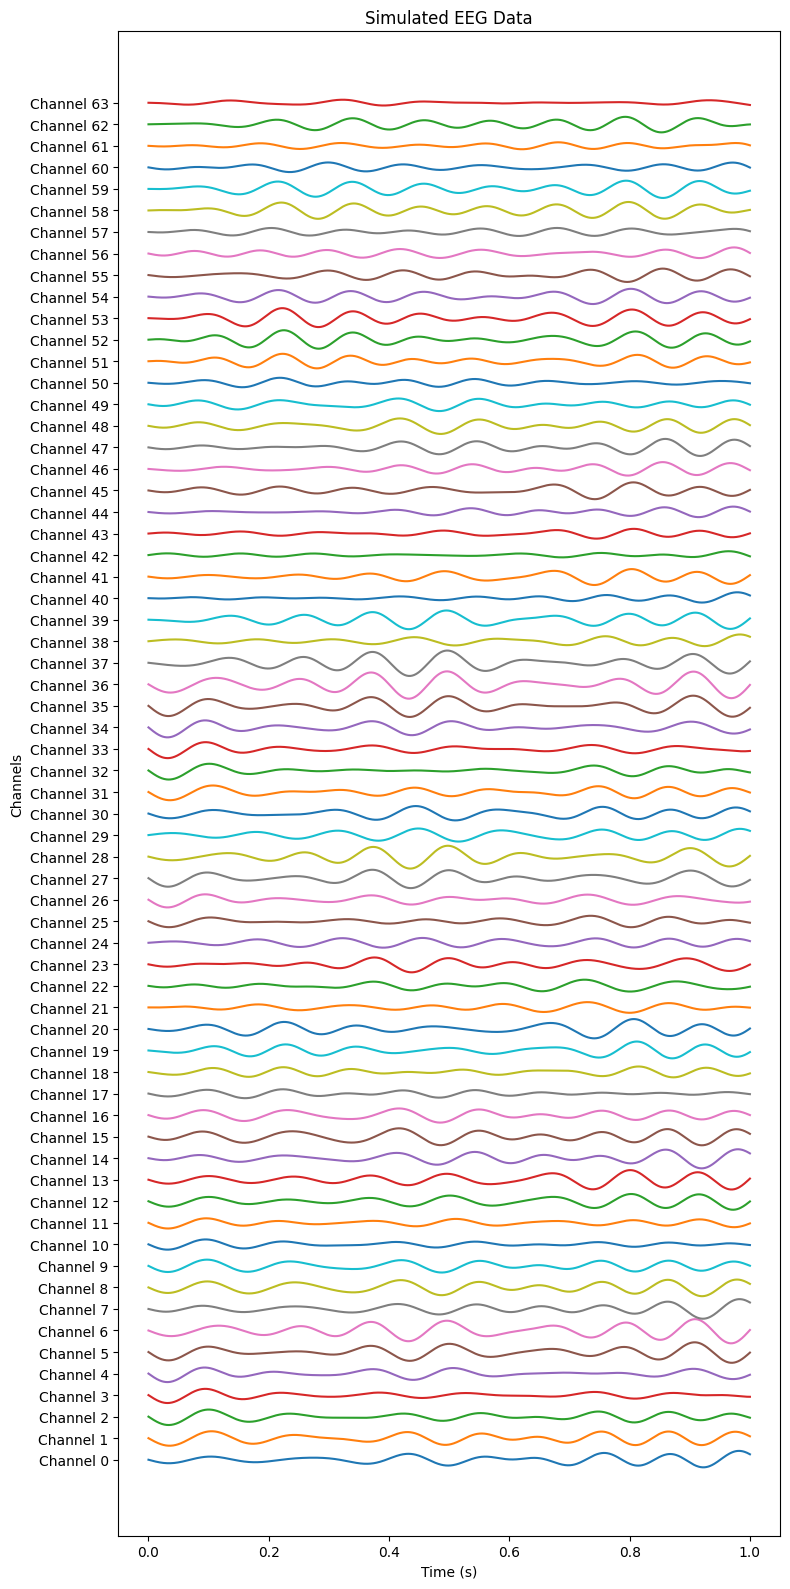

In [12]:
simulated_source_data, time = object.simulated_source_data(
    leadfield_downsampled=leadfield_downsampled, 
    timepoints_number=1000, 
    frequency_parameter=(5,10), 
    time_parameter=(0, 1)
    )# Generate simulated source data.

simulated_eeg_data = object.simulated_eeg_data(
    simulated_source_data=simulated_source_data, 
    leadfield_downsampled=leadfield_downsampled, 
    time=time, visualization=True, 
    plot_title="Simulated EEG Data", 
    plot_offset=None,  plot_size=(8, 16),
    csv_file_name="simulated_eeg_data.csv", 
    folder_to_save_csv=None)# Calculate simulated EEG data, plot and store are optional.


### Obtain the index of regions in AAL2
The index of region in AAL2 atlas can be aquired, here in the example, the index of precentral gyrus is found.

In [13]:
object.view_all_region_names(atlas_xml_path)

Precentral_L_index = object.find_region_corresponding_index(
    atlas_xml_path=atlas_xml_path, region_name = 'Precentral_L'
    )

Precentral_R_index = object.find_region_corresponding_index(
    atlas_xml_path=atlas_xml_path, region_name = 'Precentral_R'
    )

all region names: ['Precentral_L', 'Precentral_R', 'Frontal_Sup_2_L', 'Frontal_Sup_2_R', 'Frontal_Mid_2_L', 'Frontal_Mid_2_R', 'Frontal_Inf_Oper_L', 'Frontal_Inf_Oper_R', 'Frontal_Inf_Tri_L', 'Frontal_Inf_Tri_R', 'Frontal_Inf_Orb_2_L', 'Frontal_Inf_Orb_2_R', 'Rolandic_Oper_L', 'Rolandic_Oper_R', 'Supp_Motor_Area_L', 'Supp_Motor_Area_R', 'Olfactory_L', 'Olfactory_R', 'Frontal_Sup_Medial_L', 'Frontal_Sup_Medial_R', 'Frontal_Med_Orb_L', 'Frontal_Med_Orb_R', 'Rectus_L', 'Rectus_R', 'OFCmed_L', 'OFCmed_R', 'OFCant_L', 'OFCant_R', 'OFCpost_L', 'OFCpost_R', 'OFClat_L', 'OFClat_R', 'Insula_L', 'Insula_R', 'Cingulate_Ant_L', 'Cingulate_Ant_R', 'Cingulate_Mid_L', 'Cingulate_Mid_R', 'Cingulate_Post_L', 'Cingulate_Post_R', 'Hippocampus_L', 'Hippocampus_R', 'ParaHippocampal_L', 'ParaHippocampal_R', 'Amygdala_L', 'Amygdala_R', 'Calcarine_L', 'Calcarine_R', 'Cuneus_L', 'Cuneus_R', 'Lingual_L', 'Lingual_R', 'Occipital_Sup_L', 'Occipital_Sup_R', 'Occipital_Mid_L', 'Occipital_Mid_R', 'Occipital_Inf_L', 

### Example of acquiring simulated EEG data based on simulated source signals with an extra stimulation at the precentral gyrus.

In this section, like before a randomly simulated brain activity was generated, through the multiplication of the lead-field matrix the simulated EEG signals are obtained. 

Then extra additive stimulations at the precentral gyrus were added to the original simulated brain activity, further multiplying it with the lead-field matrix to acquire the simulated EEG signals that have additional stimulation at precentral gyrus areas. 

Finally, plot the two EEG data, and store them as CSV files for statistical and medical analysis.

The simulated data and external additive stimulation regions can be manually adjusted.

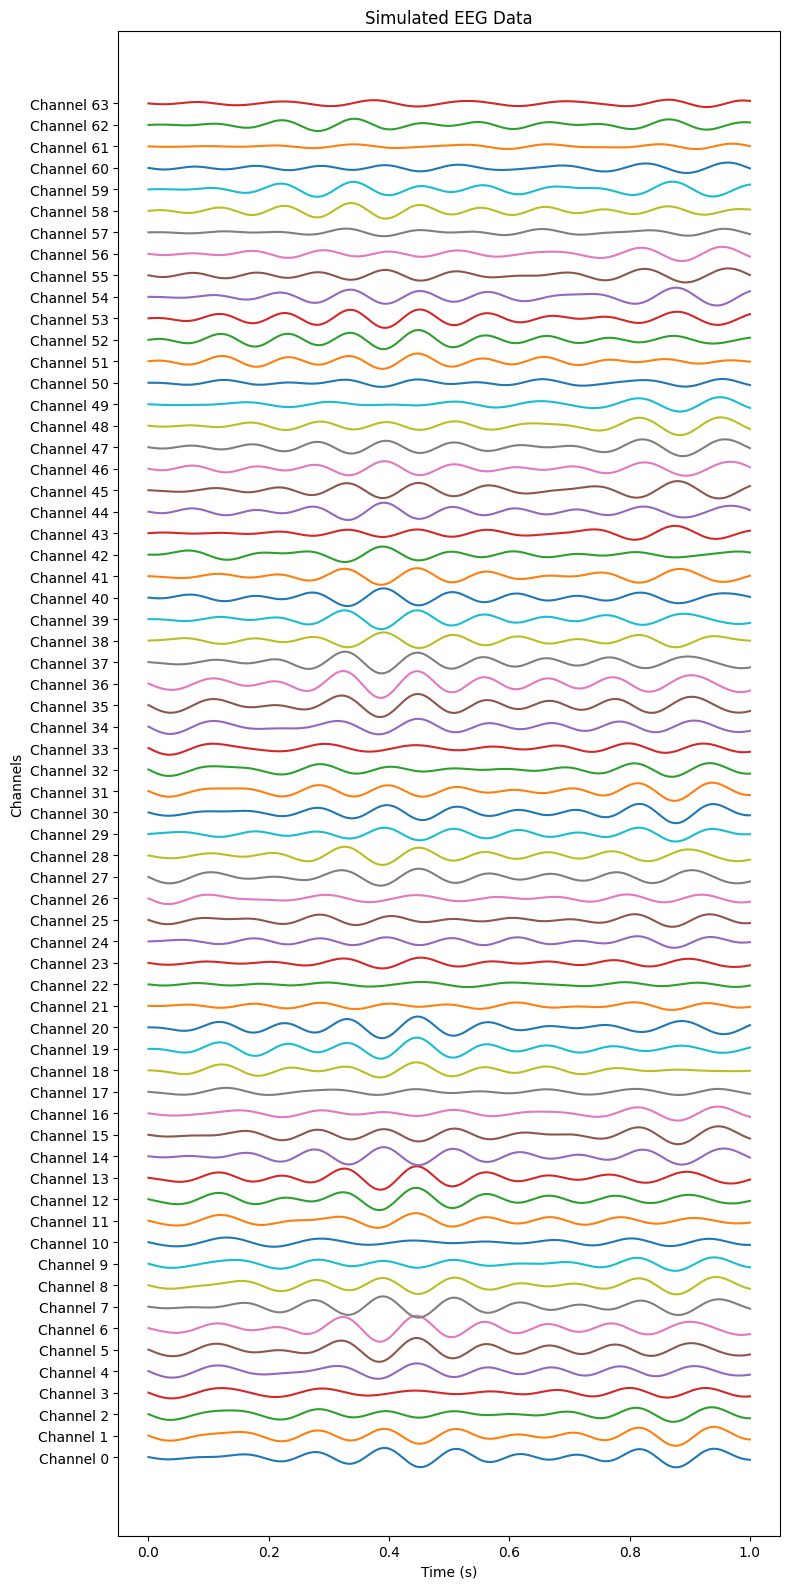

The simulated EEG data is saved as a csv file at examples/data/AAL2_atlas_data/simulated_eeg_data.csv


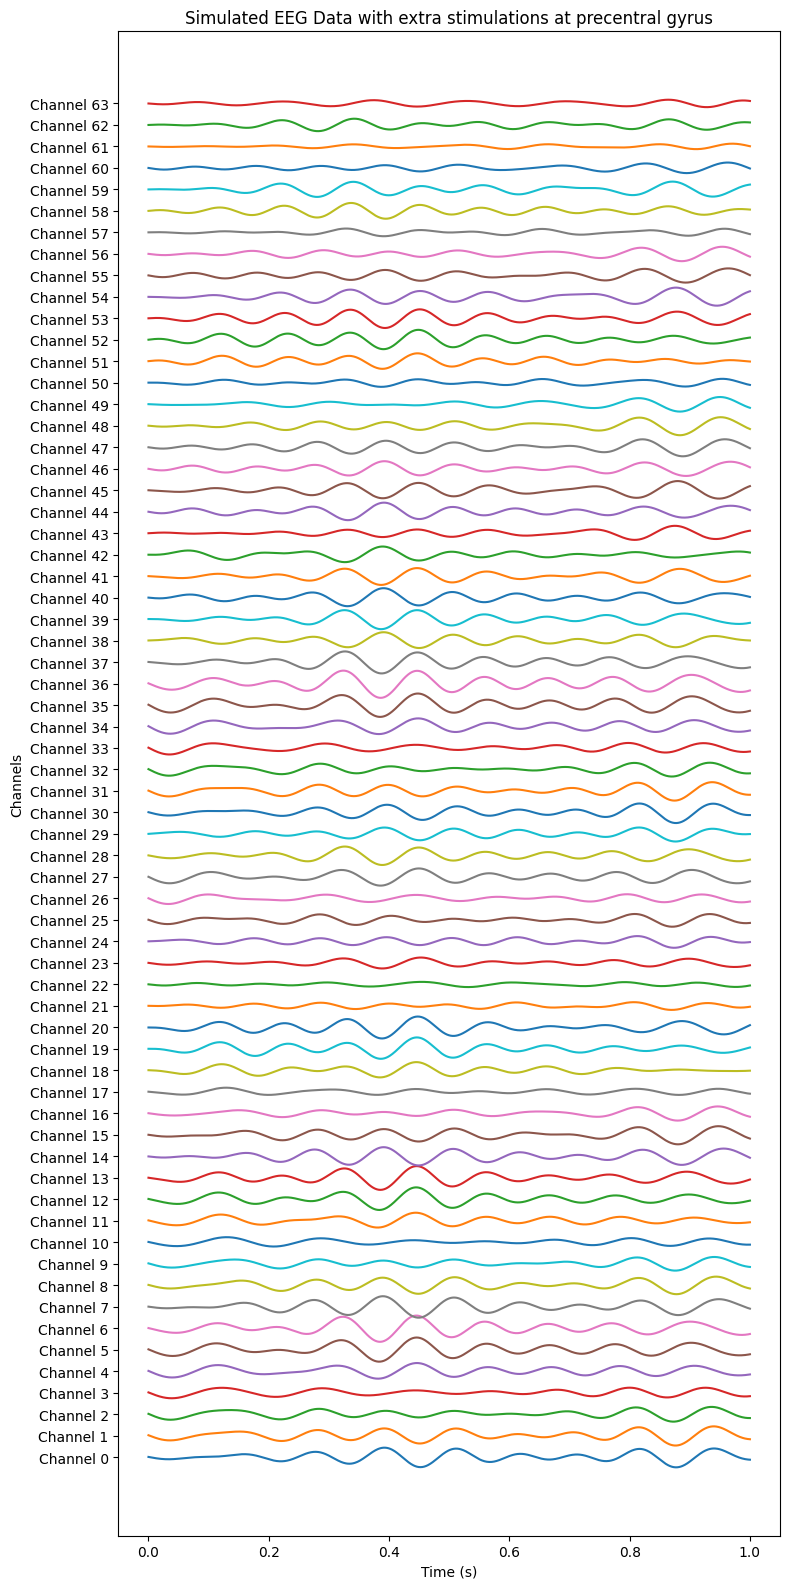

The simulated EEG data is saved as a csv file at examples/data/AAL2_atlas_data/simulated_eeg_data_extra_stimulated.csv


In [14]:
simulated_source_data, time = object.simulated_source_data(
    leadfield_downsampled=leadfield_downsampled, 
    timepoints_number=1000, 
    frequency_parameter=(5,10), 
    time_parameter=(0, 1)
    )# Generate simulated source data

simulated_eeg_data = object.simulated_eeg_data(
    simulated_source_data=simulated_source_data, 
    leadfield_downsampled=leadfield_downsampled, 
    time=time, visualization=True, 
    plot_title="Simulated EEG Data", 
    plot_offset=None,  plot_size=(8, 16),
    csv_file_name="simulated_eeg_data.csv", 
    folder_to_save_csv="examples/data/AAL2_atlas_data")# Calculate simulated EEG data

import numpy as np

# Introduce external stimulation at precentral gyrus, which corresponding to indices 0 and 1
simulated_source_data_extra_stimulated = np.copy(simulated_source_data)
stimulation_magnitude = np.max(simulated_source_data) * 0.5  # Define an appropriate stimulation magnitude

# Linearly adding the extra stimulations.
simulated_source_data_extra_stimulated[Precentral_L_index] += stimulation_magnitude
simulated_source_data_extra_stimulated[Precentral_R_index] += stimulation_magnitude

# Compute the simulated EEG data with the extra stimulations at the precentral gyrus
simulated_eeg_data_stimulated = object.simulated_eeg_data(
    simulated_source_data=simulated_source_data_extra_stimulated, 
    leadfield_downsampled=leadfield_downsampled, 
    time=time, visualization=True, 
    plot_title="Simulated EEG Data with extra stimulations at precentral gyrus", 
    plot_offset=None,  plot_size=(8, 16),
    csv_file_name="simulated_eeg_data_extra_stimulated.csv", 
    folder_to_save_csv="examples/data/AAL2_atlas_data")
